In [ ]:
! pip install -q transformers

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

In [ ]:
df = pd.read_csv('data.csv')

In [ ]:
df.describe()

,Sentence,Sentiment
count,5842,5842
unique,5322,3
top,Managing Director 's comments : `` Net sales f...,neutral
freq,2,3130


In [ ]:
df = df.drop_duplicates(subset=['Sentence'],keep='last')

In [ ]:
df = df.replace({'Sentiment':{'positive':2,'neutral':1,'negative':0}})
df['Sentiment'] = df['Sentiment'].values.tolist()

<Axes: xlabel='Sentiment', ylabel='count'>

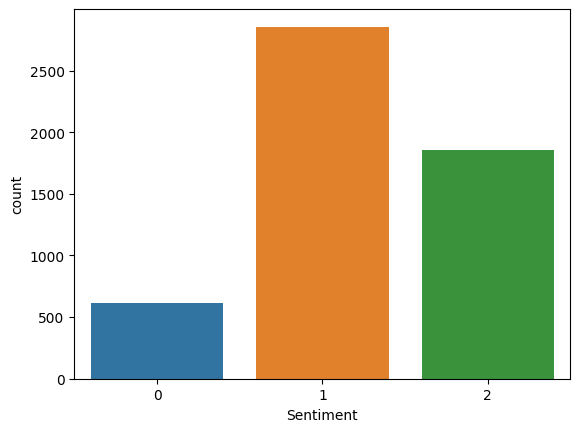

In [ ]:
sns.countplot(x=df['Sentiment'])

In [ ]:
train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=200)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

In [ ]:
final_train_size = 0.9
final_train_dataset=train_dataset.sample(frac=final_train_size,random_state=200)
valid_dataset=train_dataset.drop(final_train_dataset.index).reset_index(drop=True)
train_dataset = final_train_dataset.reset_index(drop=True)

In [ ]:
print(df.size)
print(train_dataset.size)
print(valid_dataset.size)
print(test_dataset.size)


print(test_dataset.size + train_dataset.size + valid_dataset.size)

10644
7664
852
2128
10644


In [ ]:
train_dataset.to_csv('train_data.csv',index=False)
test_dataset.to_csv('test_data.csv',index=False)
valid_dataset.to_csv('valid_data.csv',index=False)

<Axes: xlabel='Sentiment', ylabel='count'>

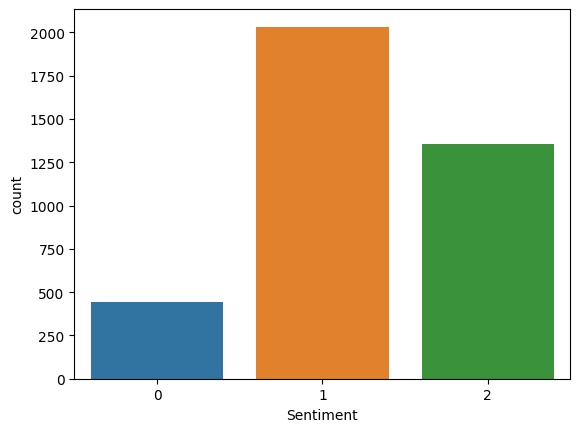

In [ ]:
# paraphrase to oversample from train_data
sns.countplot(x=train_dataset['Sentiment'],order=[0,1,2])

In [ ]:
#oversampling using paraphrasing
model_name = 'tuner007/pegasus_paraphrase'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)

In [ ]:
def get_response(input_text,num_return_sequences,num_beams):
  batch = tokenizer([input_text],truncation=True,padding='longest',max_length=200, return_tensors="pt").to(device)
  translated = model.generate(**batch,max_length=200,num_beams=num_beams, num_return_sequences=num_return_sequences, temperature=1.5)
  tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
  return tgt_text

In [ ]:
test = train_dataset.iloc[1]['Sentence']
res  = get_response(test,1,10)
res2 = get_response(res[0],1,10)
print('Original sentence:', test)
print('After paraphrase:', res[0])
print('After paraphrase again :', res2[0])

Original sentence: The last job losses related to these reductions will take place during 2010 .
After paraphrase: There will be job losses in 2010 related to these reductions.
After paraphrase again : There will be job losses in 2010.


In [ ]:
#negative oversampling
negative_df = train_dataset[train_dataset['Sentiment']==0]
res_df = []
for sentence in negative_df[0:]['Sentence']:
  try:
    res = get_response(sentence,1,1)[0]
  except:
    continue
  res = {'Sentence':res,'Sentiment':0}
  res_df.append(res)

res_df = pd.DataFrame(res_df)

In [ ]:
res_df.to_csv('negative_oversampling.csv',index=False)

In [ ]:
oversample_data = pd.concat([train_dataset,res_df],axis=0)

In [ ]:
#positive oversampling
diff = len(train_dataset[train_dataset['Sentiment']==1]) -  len(train_dataset[train_dataset['Sentiment']==2])
positive_df = train_dataset[train_dataset['Sentiment']==2]
res_df = []
chosen = np.random.randint(0,len(positive_df),size=diff)

In [ ]:
sentence = positive_df.iloc[chosen]['Sentence']
for sent in sentence:
  try:
    res = get_response(str(sent),1,1)[0]
    res = {'Sentence':res,'Sentiment':2}
    res_df.append(res)
  except:
    continue

res_df = pd.DataFrame(res_df)

In [ ]:
res_df.to_csv('positive_oversampling.csv',index=False)

In [ ]:
oversample_data = pd.concat([oversample_data,res_df],axis=0)
oversample_data.to_csv('oversample_train.csv',index=False)

<Axes: xlabel='Sentiment', ylabel='count'>

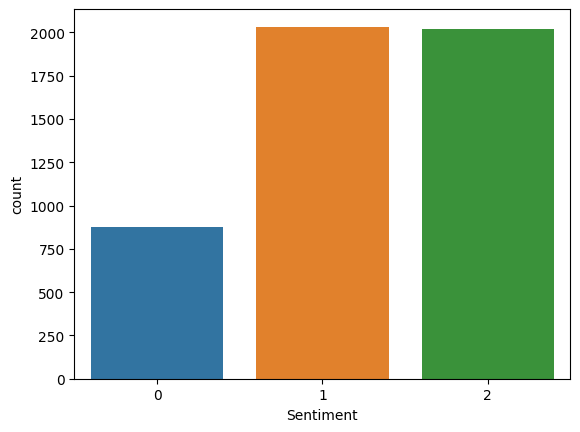

In [ ]:
sns.countplot(x=oversample_data['Sentiment'],order=[0,1,2])